### **IRIS DATASET**

In [ ]:
# Cell 1: Load & preprocess Iris

import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load data
iris = load_iris()
X = iris.data             # (150, 4)
y = iris.target           # shape (150,)  ← store as 1‑D

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One‑hot encode labels as dense array
encoder = OneHotEncoder(sparse_output=False)       # for sklearn ≥1.2
Y_onehot = encoder.fit_transform(y.reshape(-1,1))  # (150, 3) ndarray

# Sanity checks
print("X_scaled shape:", X_scaled.shape)
print("Y_onehot shape:", Y_onehot.shape, "dtype:", Y_onehot.dtype)

# Recover labels via argmax
y_flat = y  # already 1‑D
recovered = np.argmax(Y_onehot, axis=1)
print("Argmax recovery correct?", np.all(recovered == y_flat))

X_scaled shape: (150, 4)
Y_onehot shape: (150, 3) dtype: float64
Argmax recovery correct? True


In [ ]:
# Cell 2: Initialize network parameters for a 4-10-3 MLP
input_size  = X_scaled.shape[1]
hidden_size = 10
output_size = Y_onehot.shape[1]
rng = np.random.default_rng(seed=42)

# Xavier initialization
W1 = rng.normal(0, np.sqrt(2/(input_size + hidden_size)), size=(input_size, hidden_size))
b1 = np.zeros(hidden_size)
W2 = rng.normal(0, np.sqrt(2/(hidden_size + output_size)), size=(hidden_size, output_size))
b2 = np.zeros(output_size)

print("\nW1 shape:", W1.shape)
print("b1 shape:", b1.shape)
print("W2 shape:", W2.shape)
print("b2 shape:", b2.shape)


W1 shape: (4, 10)
b1 shape: (10,)
W2 shape: (10, 3)
b2 shape: (3,)


In [ ]:
# Cell 3: Define activation functions and the forward pass

import numpy as np

# Activation functions
def tanh(x):
    return np.tanh(x)
def dtanh(x):
    return 1 - np.tanh(x)**2

def softmax(x):
    # Numerically stable softmax
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Forward pass function
def forward_pass(X, W1, b1, W2, b2):
    """
    Compute the forward pass of a 1-hidden-layer MLP:
      - Hidden: z1 = X @ W1 + b1, a1 = relu(z1)
      - Output: z2 = a1 @ W2 + b2, a2 = softmax(z2)
    Returns tuple (z1, a1, z2, a2)
    """
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

# Test forward pass on first 5 samples
z1_test, a1_test, z2_test, a2_test = forward_pass(X_scaled[:5], W1, b1, W2, b2)

print("z1_test shape:", z1_test.shape)
print("a1_test shape:", a1_test.shape)
print("z2_test shape:", z2_test.shape)
print("a2_test (probabilities) shape:", a2_test.shape)
print("\nSample output probabilities:\n", a2_test)

z1_test shape: (5, 10)
a1_test shape: (5, 10)
z2_test shape: (5, 3)
a2_test (probabilities) shape: (5, 3)

Sample output probabilities:
 [[0.27509218 0.34690316 0.37800466]
 [0.19075751 0.25436085 0.55488164]
 [0.19253338 0.28674101 0.52072562]
 [0.17459768 0.27346167 0.55194065]
 [0.27444863 0.36655328 0.3589981 ]]


In [ ]:
# Cell 4: Loss function (cross-entropy) and test
import numpy as np

def compute_loss(a2, Y):
    """
    Compute average cross-entropy loss.
    a2: (N, C) predicted probabilities
    Y: (N, C) one-hot true labels
    """
    N = Y.shape[0]
    # Convert sparse matrix Y to dense numpy array if it is sparse
    if hasattr(Y, 'toarray'):
        Y = Y.toarray()
    # Clip for numerical stability
    a2_clipped = np.clip(a2, 1e-12, 1.0)
    loss = -np.sum(Y * np.log(a2_clipped)) / N
    return loss

# Test loss on initial forward pass
initial_loss = compute_loss(a2_test, Y_onehot[:5])
print("Initial loss on first 5 samples:", initial_loss)

Initial loss on first 5 samples: 1.5266298348879475


In [ ]:
# Cell 5: Gradient computation (backpropagation)
def compute_gradients(X, Y, W1, b1, W2, b2):
    """
    Compute gradients of the loss w.r.t. W1, b1, W2, b2.
    """
    N = X.shape[0]
    # Convert sparse matrix Y to dense numpy array if it is sparse
    if hasattr(Y, 'toarray'):
        Y = Y.toarray()
    # Forward
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    a2 = softmax(z2)

    # Backprop
    delta2 = (a2 - Y) / N                # (N, C)
    # Ensure delta2 is a dense numpy array
    if hasattr(delta2, 'toarray'):
        delta2 = delta2.toarray()
    grad_W2 = a1.T.dot(delta2)           # (H, C)
    grad_b2 = np.sum(delta2, axis=0)     # (C,)

    # Derivative through ReLU
    dtanh = 1 - np.tanh(z1)**2      # shape (N, H)
    delta1 = delta2.dot(W2.T) * dtanh

    grad_W1 = X.T.dot(delta1)            # (D, H)
    grad_b1 = np.sum(delta1, axis=0)     # (H,)

    return grad_W1, grad_b1, grad_W2, grad_b2

# Test gradients shapes
grads = compute_gradients(X_scaled[:5], Y_onehot[:5], W1, b1, W2, b2)
print("Grad W1 shape:", grads[0].shape)
print("Grad b1 shape:", grads[1].shape)
print("Grad W2 shape:", grads[2].shape)
print("Grad b2 shape:", grads[3].shape)

Grad W1 shape: (4, 10)
Grad b1 shape: (10,)
Grad W2 shape: (10, 3)
Grad b2 shape: (3,)


In [ ]:
# Cell 6: Numerical gradient check for W1[0,0]
epsilon = 1e-5
# Analytical gradient
grad_W1, _, _, _ = grads
analytic_grad = grad_W1[0,0]

# Numerical approximation
orig = W1[0,0]
W1[0,0] = orig + epsilon
_, _, _, a2_plus = forward_pass(X_scaled[:5], W1, b1, W2, b2)
loss_plus = compute_loss(a2_plus, Y_onehot[:5])

W1[0,0] = orig - epsilon
_, _, _, a2_minus = forward_pass(X_scaled[:5], W1, b1, W2, b2)
loss_minus = compute_loss(a2_minus, Y_onehot[:5])

# Restore original
W1[0,0] = orig

numeric_grad = (loss_plus - loss_minus) / (2 * epsilon)
print(f"Analytic grad W1[0,0]: {analytic_grad:.6f}")
print(f"Numeric  grad W1[0,0]: {numeric_grad:.6f}")
print(f"Difference: {abs(analytic_grad - numeric_grad):.6e}")

Analytic grad W1[0,0]: 0.150665
Numeric  grad W1[0,0]: 0.150665
Difference: 4.505646e-12


### **SGD**

In [ ]:
# Cell 7: Revised SGD Training Loop with Diagnostics

import time
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 1.0
epochs = 500
batch_size = 16
N = X_scaled.shape[0]

# Re‑initialize weights & biases
rng = np.random.default_rng(42)
W1 = rng.normal(0, np.sqrt(2/(input_size + hidden_size)), (input_size, hidden_size))
b1 = np.full(hidden_size, 0.1)
W2 = rng.normal(loc=0.0, scale=0.01, size=(hidden_size, output_size))
b2 = rng.normal(loc=0.0, scale=0.01, size=(output_size,))

# Histories
loss_history = []
accuracy_history = []
grad_norm_history = []

start_time = time.time()

for epoch in range(1, epochs + 1):
    # Shuffle dataset
    perm = rng.permutation(N)
    X_sh, Y_sh = X_scaled[perm], Y_onehot[perm]

    # Mini‑batch updates
    for i in range(0, N, batch_size):
        X_batch = X_sh[i:i+batch_size]
        Y_batch = Y_sh[i:i+batch_size]

        # Forward & backward on the batch
        _, a1_b, _, a2_b = forward_pass(X_batch, W1, b1, W2, b2)
        grad_W1, grad_b1, grad_W2, grad_b2 = compute_gradients(X_batch, Y_batch, W1, b1, W2, b2)

        # Parameter update
        W1 -= learning_rate * grad_W1
        b1 -= learning_rate * grad_b1
        W2 -= learning_rate * grad_W2
        b2 -= learning_rate * grad_b2

    # After forward pass on full dataset
    _, _, _, a2_full = forward_pass(X_scaled, W1, b1, W2, b2)
    preds = np.argmax(a2_full, axis=1)
    acc   = np.mean(preds == y_flat)   # <-- use y_flat here

    # Compute loss
    loss = compute_loss(a2_full, Y_onehot)

    # Compute gradient norm on full set
    gW1, gb1, gW2, gb2 = compute_gradients(X_scaled, Y_onehot, W1, b1, W2, b2)
    grad_norm = np.linalg.norm(gW1) + np.linalg.norm(gW2) + np.linalg.norm(gb1) + np.linalg.norm(gb2)

    # Record into histories
    loss_history.append(loss)
    accuracy_history.append(acc)
    grad_norm_history.append(grad_norm)

    # Logging and diagnostics every 50 epochs
    if epoch % 50 == 0 or epoch == 1:
        # Force 1-D numpy integer arrays
        u_preds, c_preds = np.unique(preds, return_counts=True)
        u_targs, c_targs = np.unique(y_flat, return_counts=True)

        print(f"Epoch {epoch}/{epochs} — Loss: {loss:.4f}, Accuracy: {acc:.4f}, Grad norm: {grad_norm:.4e}")
        print(f"  Pred counts: {{ {', '.join(f'{k}: {v}' for k, v in zip(u_preds, c_preds))} }}")
        print(f"  Target counts: {{ {', '.join(f'{k}: {v}' for k, v in zip(u_targs, c_targs))} }}")
        print(f"  Example probabilities [0]: {a2_full[0]}")

end_time = time.time()
print(f"\nTotal training time: {end_time - start_time:.2f} seconds")

Epoch 1/500 — Loss: 0.5337, Accuracy: 0.6867, Grad norm: 1.2914e+00
  Pred counts: { 0: 50, 1: 97, 2: 3 }
  Target counts: { 0: 50, 1: 50, 2: 50 }
  Example probabilities [0]: [0.98269486 0.01418196 0.00312318]
Epoch 50/500 — Loss: 0.0463, Accuracy: 0.9800, Grad norm: 1.2381e-01
  Pred counts: { 0: 50, 1: 47, 2: 53 }
  Target counts: { 0: 50, 1: 50, 2: 50 }
  Example probabilities [0]: [9.99411362e-01 5.88636579e-04 9.31545169e-10]
Epoch 100/500 — Loss: 0.0475, Accuracy: 0.9800, Grad norm: 1.6583e-01
  Pred counts: { 0: 50, 1: 47, 2: 53 }
  Target counts: { 0: 50, 1: 50, 2: 50 }
  Example probabilities [0]: [9.99567841e-01 4.32159087e-04 1.16898057e-10]
Epoch 150/500 — Loss: 0.0326, Accuracy: 0.9933, Grad norm: 2.8176e-02
  Pred counts: { 0: 50, 1: 49, 2: 51 }
  Target counts: { 0: 50, 1: 50, 2: 50 }
  Example probabilities [0]: [9.99734771e-01 2.65229200e-04 2.71338377e-11]
Epoch 200/500 — Loss: 0.0289, Accuracy: 0.9933, Grad norm: 8.2409e-03
  Pred counts: { 0: 50, 1: 49, 2: 51 }
  T

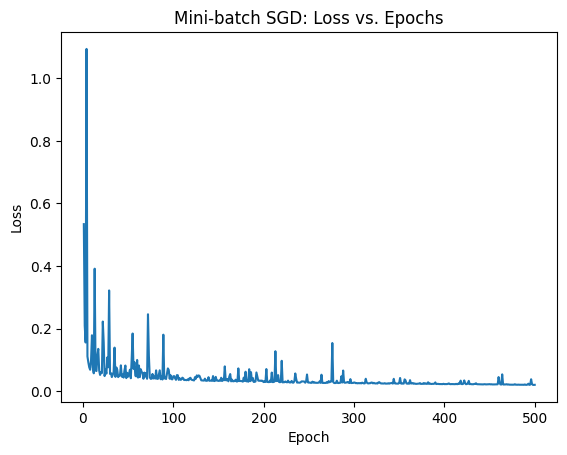

In [ ]:
# Cell 8: Plot Loss vs. Epochs
plt.figure()
plt.plot(range(1, epochs + 1), loss_history)
plt.title("Mini‑batch SGD: Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

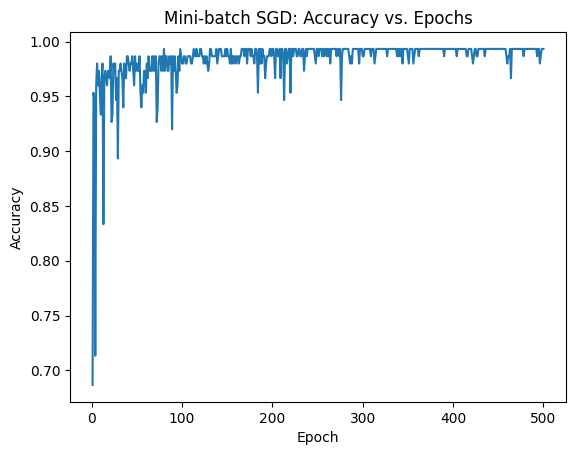

In [ ]:
# Cell 9: Plot Accuracy vs. Epochs
plt.figure()
plt.plot(range(1, epochs + 1), accuracy_history)
plt.title("Mini‑batch SGD: Accuracy vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### **Hessian/Newton mthd**

In [ ]:
# Cell 10: Flatten/unflatten utilities and vectorized loss/grad

import numpy as np

def pack_params(W1, b1, W2, b2):
    return np.concatenate([W1.ravel(), b1, W2.ravel(), b2])

def unpack_params(theta):
    # Compute sizes
    i, h, o = input_size, hidden_size, output_size
    w1_size = i*h
    b1_size = h
    w2_size = h*o
    b2_size = o

    W1 = theta[:w1_size].reshape(i, h)
    b1 = theta[w1_size:w1_size+b1_size]
    W2 = theta[w1_size+b1_size:w1_size+b1_size+w2_size].reshape(h, o)
    b2 = theta[-b2_size:]
    return W1, b1, W2, b2

def loss_vec(theta):
    W1_, b1_, W2_, b2_ = unpack_params(theta)
    _, _, _, a2_ = forward_pass(X_scaled, W1_, b1_, W2_, b2_)
    return compute_loss(a2_, Y_onehot)

def grad_vec(theta):
    W1_, b1_, W2_, b2_ = unpack_params(theta)
    gW1, gb1, gW2, gb2 = compute_gradients(X_scaled, Y_onehot, W1_, b1_, W2_, b2_)
    return pack_params(gW1, gb1, gW2, gb2)

# Initialize theta0
theta0 = pack_params(W1, b1, W2, b2)


Iter 1/500 — Loss: 2.1584, Accuracy: 0.6267
Iter 2/500 — Loss: 15.6576, Accuracy: 0.4333
Iter 3/500 — Loss: 18.6049, Accuracy: 0.3267
Iter 4/500 — Loss: 7.5525, Accuracy: 0.7267
Iter 5/500 — Loss: 8.1051, Accuracy: 0.7067
Iter 6/500 — Loss: 7.9209, Accuracy: 0.7133
Iter 7/500 — Loss: 8.6577, Accuracy: 0.6867
Iter 8/500 — Loss: 7.3683, Accuracy: 0.7333
Iter 9/500 — Loss: 4.7894, Accuracy: 0.8267
Iter 10/500 — Loss: 2.9473, Accuracy: 0.8933
Iter 11/500 — Loss: 4.0525, Accuracy: 0.8533
Iter 12/500 — Loss: 4.0525, Accuracy: 0.8533
Iter 13/500 — Loss: 4.2368, Accuracy: 0.8467
Iter 14/500 — Loss: 3.3157, Accuracy: 0.8800
Iter 15/500 — Loss: 2.2105, Accuracy: 0.9200
Iter 16/500 — Loss: 2.5789, Accuracy: 0.9067
Iter 17/500 — Loss: 2.2105, Accuracy: 0.9200
Iter 18/500 — Loss: 2.2585, Accuracy: 0.9133
Iter 19/500 — Loss: 2.5789, Accuracy: 0.9067
Iter 20/500 — Loss: 4.2368, Accuracy: 0.8467
Iter 21/500 — Loss: 3.4999, Accuracy: 0.8733
Iter 22/500 — Loss: 2.9473, Accuracy: 0.8933
Iter 23/500 — Los

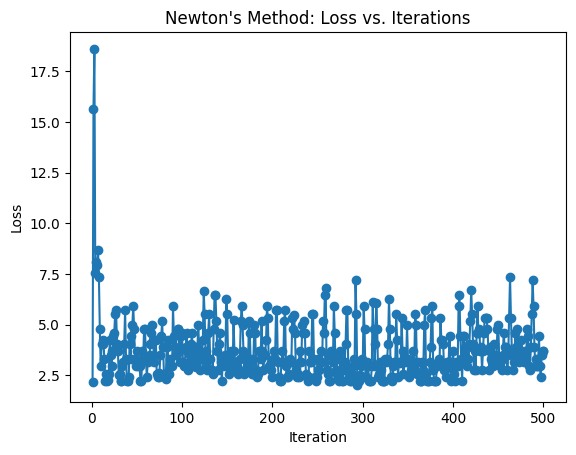

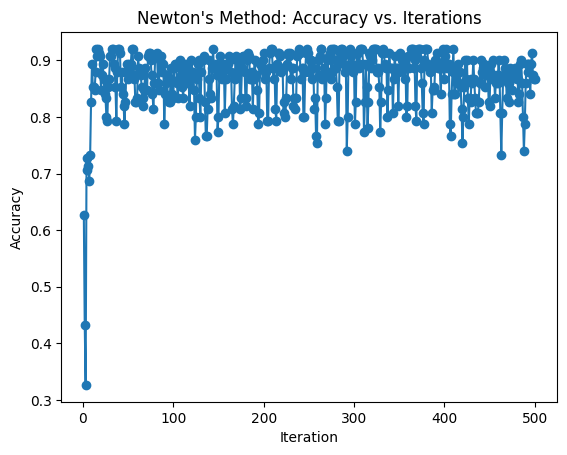

In [ ]:
# Cell 11: Newton’s Method Implementation for MLP on Iris

import time
import numpy as np
import matplotlib.pyplot as plt

# Finite-difference Hessian approximation
def compute_hessian(theta, grad_func, eps=1e-5):
    n = theta.size
    H = np.zeros((n, n))
    # Compute central differences of gradient
    for i in range(n):
        # Perturb basis vector
        ei = np.zeros_like(theta)
        ei[i] = eps
        g_plus  = grad_func(theta + ei)
        g_minus = grad_func(theta - ei)
        H[:, i] = (g_plus - g_minus) / (2 * eps)
    return H

# Newton training loop
max_iter = 500
damping = 1e-4

# Initialize theta
theta = theta0.copy()

newton_loss = []
newton_acc  = []

start_time = time.time()

for it in range(1, max_iter + 1):
    # Compute gradient and Hessian
    g = grad_vec(theta)
    H = compute_hessian(theta, grad_vec)
    # Damped Newton step
    delta = np.linalg.solve(H + damping * np.eye(H.shape[0]), g)
    theta -= delta

    # Evaluate performance
    W1_n, b1_n, W2_n, b2_n = unpack_params(theta)
    _, _, _, a2_n = forward_pass(X_scaled, W1_n, b1_n, W2_n, b2_n)
    loss_n = compute_loss(a2_n, Y_onehot)
    acc_n  = np.mean(np.argmax(a2_n, axis=1) == y_flat)

    newton_loss.append(loss_n)
    newton_acc.append(acc_n)

    print(f"Iter {it}/{max_iter} — Loss: {loss_n:.4f}, Accuracy: {acc_n:.4f}")

total_time = time.time() - start_time
print(f"\nTotal Newton training time: {total_time:.2f} seconds")

# Plotting Newton convergence
plt.figure()
plt.plot(range(1, max_iter+1), newton_loss, marker='o')
plt.title("Newton's Method: Loss vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(range(1, max_iter+1), newton_acc, marker='o')
plt.title("Newton's Method: Accuracy vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()


Auto-damping

Iter 1/500 — Loss: 0.0202, Accuracy: 0.9933, Damping: 2.0e-03
Iter 2/500 — Loss: 0.0202, Accuracy: 0.9933, Damping: 4.0e-03
Iter 3/500 — Loss: 0.0188, Accuracy: 0.9933, Damping: 3.2e-03
Iter 4/500 — Loss: 0.0188, Accuracy: 0.9933, Damping: 6.4e-03
Iter 5/500 — Loss: 0.0188, Accuracy: 0.9933, Damping: 1.3e-02
Iter 6/500 — Loss: 0.0177, Accuracy: 0.9933, Damping: 1.0e-02
Iter 7/500 — Loss: 0.0169, Accuracy: 0.9933, Damping: 8.2e-03
Iter 8/500 — Loss: 0.0158, Accuracy: 0.9933, Damping: 6.6e-03
Iter 9/500 — Loss: 0.0143, Accuracy: 0.9933, Damping: 5.2e-03
Iter 10/500 — Loss: 0.0122, Accuracy: 0.9933, Damping: 4.2e-03
Iter 11/500 — Loss: 0.0097, Accuracy: 1.0000, Damping: 3.4e-03
Iter 12/500 — Loss: 0.0071, Accuracy: 1.0000, Damping: 2.7e-03
Iter 13/500 — Loss: 0.0049, Accuracy: 1.0000, Damping: 2.1e-03
Iter 14/500 — Loss: 0.0035, Accuracy: 1.0000, Damping: 1.7e-03
Iter 15/500 — Loss: 0.0025, Accuracy: 1.0000, Damping: 1.4e-03
Iter 16/500 — Loss: 0.0019, Accuracy: 1.0000, Damping: 1.1e-03
I

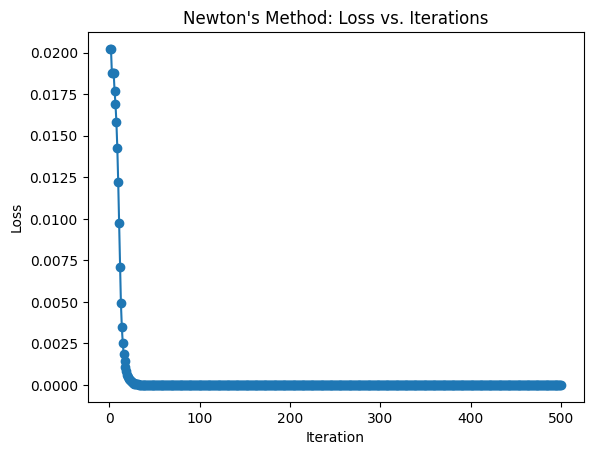

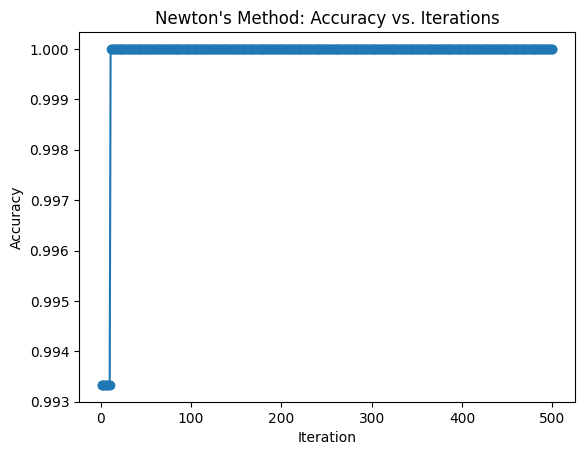

In [ ]:
# Newton training loop with auto-tuned damping
max_iter = 500
damping = 1e-3  # initial damping

theta = theta0.copy()
newton_loss = []
newton_acc  = []

start_time = time.time()

for it in range(1, max_iter + 1):
    g = grad_vec(theta)
    H = compute_hessian(theta, grad_vec)

    loss_prev = compute_loss(forward_pass(X_scaled, *unpack_params(theta))[-1], Y_onehot)
    theta_prev = theta.copy()

    try:
        # Attempt Newton step with damping
        delta = np.linalg.solve(H + damping * np.eye(H.shape[0]), g)
        theta -= delta
    except np.linalg.LinAlgError:
        print(f"LinAlgError at iteration {it} — increasing damping.")
        damping *= 10
        continue

    # Evaluate updated parameters
    W1_n, b1_n, W2_n, b2_n = unpack_params(theta)
    _, _, _, a2_n = forward_pass(X_scaled, W1_n, b1_n, W2_n, b2_n)
    loss_new = compute_loss(a2_n, Y_onehot)
    acc_n    = np.mean(np.argmax(a2_n, axis=1) == y_flat)

    # Auto-tune damping
    if loss_new < loss_prev:
        damping *= 0.8  # trust Newton more
    else:
        damping *= 2.0  # trust Newton less
        theta = theta_prev  # revert to previous weights
        loss_new = loss_prev
        acc_n = np.mean(np.argmax(forward_pass(X_scaled, *unpack_params(theta))[-1], axis=1) == y_flat)

    newton_loss.append(loss_new)
    newton_acc.append(acc_n)

    print(f"Iter {it}/{max_iter} — Loss: {loss_new:.4f}, Accuracy: {acc_n:.4f}, Damping: {damping:.1e}")

total_time = time.time() - start_time
print(f"\nTotal Newton training time: {total_time:.2f} seconds")

# Plotting Newton convergence
plt.figure()
plt.plot(range(1, max_iter+1), newton_loss, marker='o')
plt.title("Newton's Method: Loss vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(range(1, max_iter+1), newton_acc, marker='o')
plt.title("Newton's Method: Accuracy vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()


### BFGS

In [ ]:
# Cell 12: BFGS Optimization using SciPy

from scipy.optimize import minimize
import time

# Helper: Pack parameters into 1D vector
def pack_params(W1, b1, W2, b2):
    return np.concatenate([W1.ravel(), b1, W2.ravel(), b2])

# Helper: Unpack 1D vector into W1, b1, W2, b2
def unpack_params(theta):
    idx = 0
    W1_size = input_size * hidden_size
    b1_size = hidden_size
    W2_size = hidden_size * output_size
    b2_size = output_size

    W1 = theta[idx : idx + W1_size].reshape(input_size, hidden_size)
    idx += W1_size
    b1 = theta[idx : idx + b1_size]
    idx += b1_size
    W2 = theta[idx : idx + W2_size].reshape(hidden_size, output_size)
    idx += W2_size
    b2 = theta[idx : idx + b2_size]
    return W1, b1, W2, b2

# Loss and gradient wrapper for SciPy
def loss_and_grad(theta):
    W1, b1, W2, b2 = unpack_params(theta)
    z1, a1, z2, a2 = forward_pass(X_scaled, W1, b1, W2, b2)
    loss = compute_loss(a2, Y_onehot)
    grad_W1, grad_b1, grad_W2, grad_b2 = compute_gradients(X_scaled, Y_onehot, W1, b1, W2, b2)
    grad = pack_params(grad_W1, grad_b1, grad_W2, grad_b2)
    return loss, grad

# Initial parameters
theta0 = pack_params(W1, b1, W2, b2)

# BFGS optimization
bfgs_loss = []
bfgs_acc = []

def callback(theta):
    W1_cb, b1_cb, W2_cb, b2_cb = unpack_params(theta)
    _, _, _, a2_cb = forward_pass(X_scaled, W1_cb, b1_cb, W2_cb, b2_cb)
    loss_cb = compute_loss(a2_cb, Y_onehot)
    acc_cb = np.mean(np.argmax(a2_cb, axis=1) == y_flat)
    bfgs_loss.append(loss_cb)
    bfgs_acc.append(acc_cb)
    print(f"Iter {len(bfgs_loss)} — Loss: {loss_cb:.4f}, Accuracy: {acc_cb:.4f}")

start_time = time.time()

result = minimize(
    fun=loss_and_grad,
    x0=theta0,
    method='BFGS',
    jac=True,
    callback=callback,
    options={'maxiter': 500, 'disp': True}
)

total_time = time.time() - start_time
print(f"\nTotal BFGS training time: {total_time:.2f} seconds")


Iter 1 — Loss: 0.0201, Accuracy: 0.9933
Iter 2 — Loss: 0.0200, Accuracy: 0.9933
Iter 3 — Loss: 0.0199, Accuracy: 0.9933
Iter 4 — Loss: 0.0198, Accuracy: 0.9933
Iter 5 — Loss: 0.0197, Accuracy: 0.9933
Iter 6 — Loss: 0.0197, Accuracy: 0.9933
Iter 7 — Loss: 0.0197, Accuracy: 0.9933
Iter 8 — Loss: 0.0194, Accuracy: 0.9933
Iter 9 — Loss: 0.0189, Accuracy: 0.9933
Iter 10 — Loss: 0.0181, Accuracy: 0.9867
Iter 11 — Loss: 0.0169, Accuracy: 0.9867
Iter 12 — Loss: 0.0152, Accuracy: 0.9933
Iter 13 — Loss: 0.0143, Accuracy: 0.9933
Iter 14 — Loss: 0.0141, Accuracy: 0.9933
Iter 15 — Loss: 0.0136, Accuracy: 0.9933
Iter 16 — Loss: 0.0127, Accuracy: 0.9933
Iter 17 — Loss: 0.0114, Accuracy: 1.0000
Iter 18 — Loss: 0.0095, Accuracy: 1.0000
Iter 19 — Loss: 0.0080, Accuracy: 1.0000
Iter 20 — Loss: 0.0073, Accuracy: 1.0000
Iter 21 — Loss: 0.0070, Accuracy: 1.0000
Iter 22 — Loss: 0.0065, Accuracy: 1.0000
Iter 23 — Loss: 0.0058, Accuracy: 1.0000
Iter 24 — Loss: 0.0049, Accuracy: 1.0000
Iter 25 — Loss: 0.0047, A

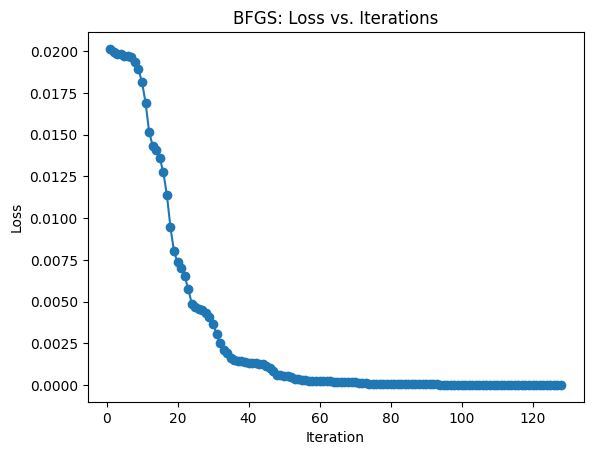

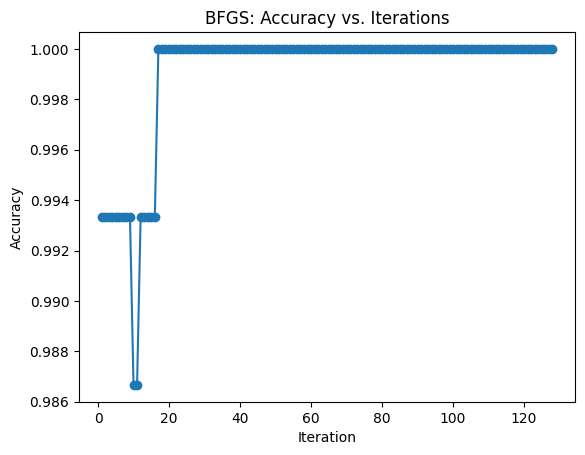

In [ ]:
# Cell 13: Plotting BFGS results
plt.figure()
plt.plot(range(1, len(bfgs_loss) + 1), bfgs_loss, marker='o')
plt.title("BFGS: Loss vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(range(1, len(bfgs_acc) + 1), bfgs_acc, marker='o')
plt.title("BFGS: Accuracy vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()


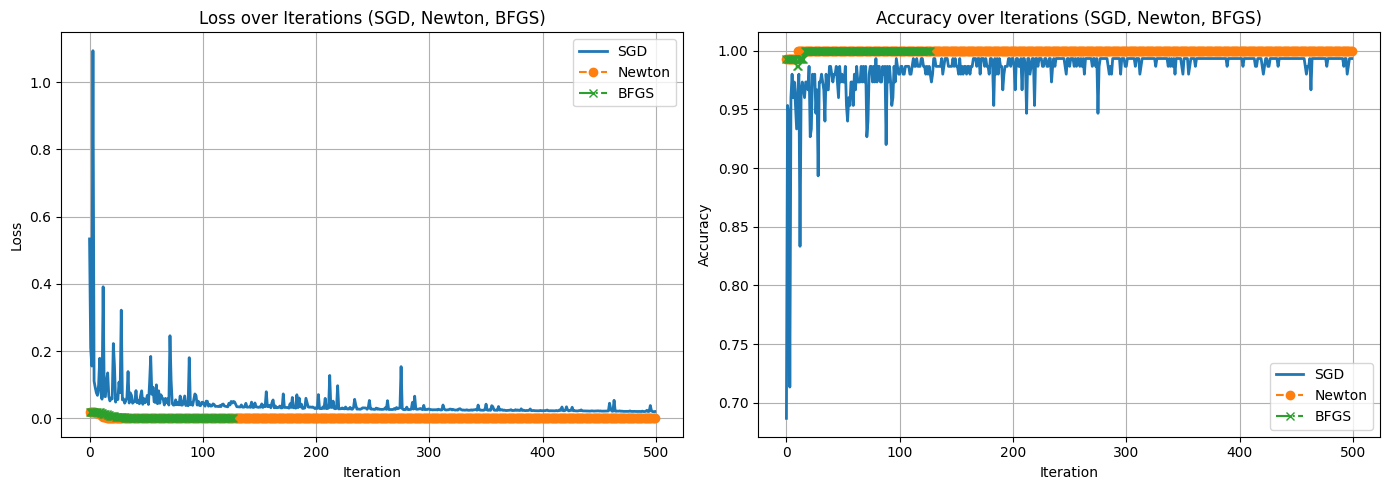

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss comparison
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label="SGD", linewidth=2)
plt.plot(newton_loss, label="Newton", marker='o', linestyle='--')
plt.plot(bfgs_loss, label="BFGS", marker='x', linestyle='-.')
plt.title("Loss over Iterations (SGD, Newton, BFGS)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label="SGD", linewidth=2)
plt.plot(newton_acc, label="Newton", marker='o', linestyle='--')
plt.plot(bfgs_acc, label="BFGS", marker='x', linestyle='-.')
plt.title("Accuracy over Iterations (SGD, Newton, BFGS)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### **Genetic Algorithm**

In [ ]:
# Flatten all parameters into a single 1D vector
def flatten_params(W1, b1, W2, b2):
    return np.concatenate([W1.ravel(), b1, W2.ravel(), b2])

# Reconstruct parameters from a flat vector
def unflatten_params(theta, input_size=4, hidden_size=10, output_size=3):
    W1_size = input_size * hidden_size
    b1_size = hidden_size
    W2_size = hidden_size * output_size
    b2_size = output_size

    W1 = theta[:W1_size].reshape((input_size, hidden_size))
    b1 = theta[W1_size:W1_size + b1_size]
    W2 = theta[W1_size + b1_size:W1_size + b1_size + W2_size].reshape((hidden_size, output_size))
    b2 = theta[-b2_size:]
    return W1, b1, W2, b2

def evaluate_accuracy(probs, y_true):
    """
    Compute classification accuracy.
    probs: (N, C) predicted probabilities
    y_true: (N,) integer labels
    """
    y_pred = np.argmax(probs, axis=1)
    return np.mean(y_pred == y_true)


In [ ]:
def fitness_fn(theta):
    W1, b1, W2, b2 = unflatten_params(theta)
    _, _, _, a2 = forward_pass(X_scaled, W1, b1, W2, b2)
    loss = compute_loss(a2, Y_onehot)
    acc = evaluate_accuracy(a2, y_flat)
    return -loss, acc  # Maximize negative loss


In [ ]:
import time

def genetic_algorithm(X, Y, input_size, hidden_size, output_size,
                      pop_size=50, generations=100, mutation_rate=0.1, elite_frac=0.1):

    param_len = input_size * hidden_size + hidden_size + hidden_size * output_size + output_size
    population = np.random.randn(pop_size, param_len) * 0.1

    elite_size = int(elite_frac * pop_size)
    loss_history, acc_history = [], []

    start_time = time.time()

    for gen in range(generations):
        fitness_scores = []
        for i in range(pop_size):
            loss, acc = fitness_fn(population[i])
            fitness_scores.append((loss, acc, i))

        # Sort by fitness (higher = better)
        fitness_scores.sort(reverse=True)
        best_loss = -fitness_scores[0][0]
        best_acc = fitness_scores[0][1]
        loss_history.append(best_loss)
        acc_history.append(best_acc)

        if gen % 10 == 0 or gen == generations - 1:
            print(f"Gen {gen+1}/{generations} — Loss: {best_loss:.4f}, Accuracy: {best_acc:.4f}")

        # Elitism
        new_population = population[[idx for (_, _, idx) in fitness_scores[:elite_size]]]

        # Generate rest via crossover + mutation
        while new_population.shape[0] < pop_size:
            p1, p2 = population[np.random.choice(pop_size, 2, replace=False)]
            crossover_point = np.random.randint(1, param_len)
            child = np.concatenate([p1[:crossover_point], p2[crossover_point:]])

            # Mutation
            mutation_mask = np.random.rand(param_len) < mutation_rate
            mutation = np.random.randn(param_len) * 0.05
            child[mutation_mask] += mutation[mutation_mask]

            new_population = np.vstack([new_population, child])

        population = new_population

    total_time = time.time() - start_time
    print(f"\nTotal GA training time: {total_time:.2f} seconds")

    # Final best solution
    best_theta = population[fitness_scores[0][2]]
    return best_theta, loss_history, acc_history


In [ ]:
best_theta_ga, ga_loss, ga_acc = genetic_algorithm(
    X_scaled, Y_onehot,
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    pop_size=50,
    generations=200,
    mutation_rate=0.1,
    elite_frac=0.1
)

# Final accuracy
W1_ga, b1_ga, W2_ga, b2_ga = unflatten_params(best_theta_ga)
_, _, _, a2_ga = forward_pass(X_scaled, W1_ga, b1_ga, W2_ga, b2_ga)
final_loss_ga = compute_loss(a2_ga, Y_onehot)
final_acc_ga = evaluate_accuracy(a2_ga, y_flat)
print(f"Final GA Accuracy: {final_acc_ga:.4f}, Loss: {final_loss_ga:.4f}")


Gen 1/200 — Loss: 1.0428, Accuracy: 0.3467
Gen 11/200 — Loss: 0.9858, Accuracy: 0.7333
Gen 21/200 — Loss: 0.9432, Accuracy: 0.7667
Gen 31/200 — Loss: 0.9231, Accuracy: 0.6933
Gen 41/200 — Loss: 0.8518, Accuracy: 0.7667
Gen 51/200 — Loss: 0.8114, Accuracy: 0.7867
Gen 61/200 — Loss: 0.7430, Accuracy: 0.7933
Gen 71/200 — Loss: 0.6695, Accuracy: 0.8200
Gen 81/200 — Loss: 0.6081, Accuracy: 0.8333
Gen 91/200 — Loss: 0.5748, Accuracy: 0.8333
Gen 101/200 — Loss: 0.5394, Accuracy: 0.8667
Gen 111/200 — Loss: 0.4990, Accuracy: 0.8467
Gen 121/200 — Loss: 0.4723, Accuracy: 0.8267
Gen 131/200 — Loss: 0.4348, Accuracy: 0.8733
Gen 141/200 — Loss: 0.4075, Accuracy: 0.8733
Gen 151/200 — Loss: 0.3822, Accuracy: 0.8933
Gen 161/200 — Loss: 0.3572, Accuracy: 0.8800
Gen 171/200 — Loss: 0.3393, Accuracy: 0.9067
Gen 181/200 — Loss: 0.3222, Accuracy: 0.9000
Gen 191/200 — Loss: 0.3038, Accuracy: 0.9067
Gen 200/200 — Loss: 0.2886, Accuracy: 0.9133

Total GA training time: 2.46 seconds
Final GA Accuracy: 0.9000, L

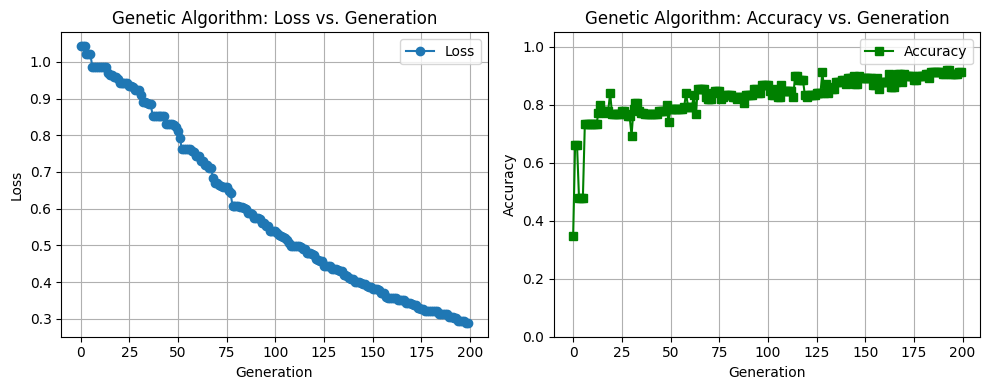

In [ ]:
import matplotlib.pyplot as plt

# Plot GA loss over generations
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(ga_loss, marker='o', label='Loss')
plt.title("Genetic Algorithm: Loss vs. Generation")
plt.xlabel("Generation")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot GA accuracy over generations
plt.subplot(1, 2, 2)
plt.plot(ga_acc, marker='s', color='green', label='Accuracy')
plt.title("Genetic Algorithm: Accuracy vs. Generation")
plt.xlabel("Generation")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### **Simulated Annealing**

In [ ]:
import numpy as np
import time

def simulated_annealing(X, Y, theta0, max_iter=1000, T_init=1.0, alpha=0.99, step_size=0.1):
    """
    Simulated Annealing optimizer for training an MLP.
    Arguments:
        X, Y: Training data and labels
        theta0: Initial flattened parameter vector
        max_iter: Total number of iterations
        T_init: Initial temperature
        alpha: Cooling rate
        step_size: Magnitude of random perturbation
    Returns:
        Best theta found, loss and accuracy over iterations
    """
    theta = theta0.copy()
    T = T_init

    def loss_fn(theta):
        W1, b1, W2, b2 = unpack_params(theta)
        _, _, _, a2 = forward_pass(X, W1, b1, W2, b2)
        return compute_loss(a2, Y)

    def accuracy_fn(theta):
        W1, b1, W2, b2 = unpack_params(theta)
        _, _, _, a2 = forward_pass(X, W1, b1, W2, b2)
        return evaluate_accuracy(a2, y_flat)

    loss_current = loss_fn(theta)
    acc_current = accuracy_fn(theta)

    best_theta = theta.copy()
    best_loss = loss_current
    best_acc = acc_current

    losses = [loss_current]
    accs = [acc_current]

    start_time = time.time()

    for i in range(1, max_iter + 1):
        # Generate neighbor
        theta_new = theta + step_size * np.random.randn(*theta.shape)
        loss_new = loss_fn(theta_new)

        # Accept or probabilistically accept worse solution
        delta = loss_new - loss_current
        if delta < 0 or np.random.rand() < np.exp(-delta / T):
            theta = theta_new
            loss_current = loss_new
            acc_current = accuracy_fn(theta)

            # Update best
            if loss_current < best_loss:
                best_theta = theta.copy()
                best_loss = loss_current
                best_acc = acc_current

        losses.append(loss_current)
        accs.append(acc_current)

        print(f"Iter {i} — Loss: {loss_current:.4f}, Accuracy: {acc_current:.4f}, Temp: {T:.4f}")
        T *= alpha  # Decrease temperature

    total_time = time.time() - start_time
    print(f"\nTotal SA training time: {total_time:.2f} seconds")

    return best_theta, losses, accs


In [ ]:
best_theta_sa, sa_loss, sa_acc = simulated_annealing(
    X_scaled, Y_onehot, theta0, max_iter=200, T_init=1.0, alpha=0.98, step_size=0.05
)

Iter 1 — Loss: 0.0201, Accuracy: 0.9933, Temp: 1.0000
Iter 2 — Loss: 0.0205, Accuracy: 0.9933, Temp: 0.9800
Iter 3 — Loss: 0.0211, Accuracy: 0.9933, Temp: 0.9604
Iter 4 — Loss: 0.0221, Accuracy: 0.9933, Temp: 0.9412
Iter 5 — Loss: 0.0220, Accuracy: 0.9933, Temp: 0.9224
Iter 6 — Loss: 0.0208, Accuracy: 0.9933, Temp: 0.9039
Iter 7 — Loss: 0.0217, Accuracy: 0.9933, Temp: 0.8858
Iter 8 — Loss: 0.0234, Accuracy: 0.9933, Temp: 0.8681
Iter 9 — Loss: 0.0262, Accuracy: 0.9933, Temp: 0.8508
Iter 10 — Loss: 0.0300, Accuracy: 0.9933, Temp: 0.8337
Iter 11 — Loss: 0.0275, Accuracy: 0.9933, Temp: 0.8171
Iter 12 — Loss: 0.0254, Accuracy: 0.9933, Temp: 0.8007
Iter 13 — Loss: 0.0261, Accuracy: 0.9933, Temp: 0.7847
Iter 14 — Loss: 0.0304, Accuracy: 0.9867, Temp: 0.7690
Iter 15 — Loss: 0.0330, Accuracy: 0.9867, Temp: 0.7536
Iter 16 — Loss: 0.0369, Accuracy: 0.9867, Temp: 0.7386
Iter 17 — Loss: 0.0445, Accuracy: 0.9867, Temp: 0.7238
Iter 18 — Loss: 0.0467, Accuracy: 0.9867, Temp: 0.7093
Iter 19 — Loss: 0.0

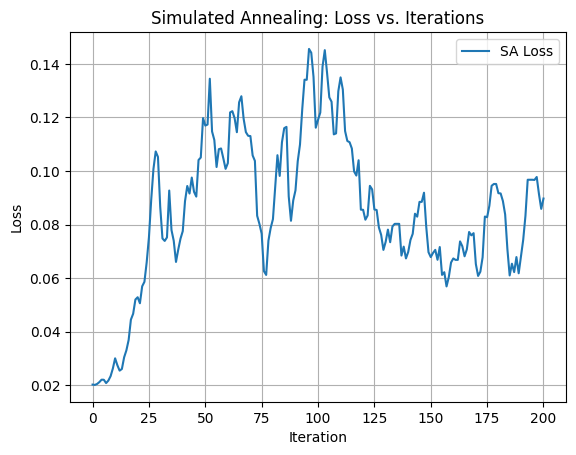

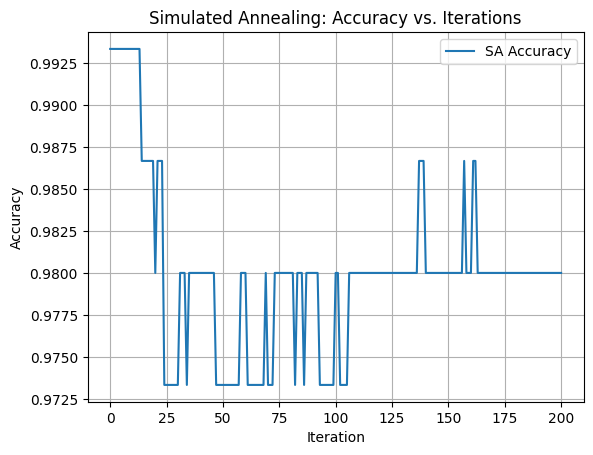

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(sa_loss, label="SA Loss")
plt.title("Simulated Annealing: Loss vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(sa_acc, label="SA Accuracy")
plt.title("Simulated Annealing: Accuracy vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

### **Particle Swarm Optimization**

In [ ]:
import numpy as np
import time


def unpack_parameters(theta, input_size, hidden_size, output_size):
    end_W1 = input_size * hidden_size
    end_b1 = end_W1 + hidden_size
    end_W2 = end_b1 + hidden_size * output_size
    end_b2 = end_W2 + output_size

    W1 = theta[:end_W1].reshape(input_size, hidden_size)
    b1 = theta[end_W1:end_b1].reshape(1, hidden_size)
    W2 = theta[end_b1:end_W2].reshape(hidden_size, output_size)
    b2 = theta[end_W2:end_b2].reshape(1, output_size)

    return W1, b1, W2, b2

def forward_pass(X, W1, b1, W2, b2):
    z1 = X @ W1 + b1
    a1 = np.tanh(z1)
    z2 = a1 @ W2 + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def compute_loss(y_pred, y_true):
    m = y_true.shape[0]
    log_likelihood = -np.log(y_pred + 1e-9) * y_true
    return np.sum(log_likelihood) / m

def evaluate_accuracy(y_pred, y_true_labels):
    preds = np.argmax(y_pred, axis=1)
    return np.mean(preds == y_true_labels)

# --- PSO Training ---

def pso_train(X, Y, input_size, hidden_size, output_size, num_particles=30, max_iter=100,
              w=0.7, c1=1.5, c2=1.5):

    dim = input_size * hidden_size + hidden_size + hidden_size * output_size + output_size

    def fitness(theta):
        W1, b1, W2, b2 = unpack_parameters(theta, input_size, hidden_size, output_size)
        _, _, _, a2 = forward_pass(X, W1, b1, W2, b2)
        loss = compute_loss(a2, Y)
        acc = evaluate_accuracy(a2, np.argmax(Y, axis=1))
        return loss, acc

    # Initialize particles
    particles = np.random.randn(num_particles, dim)
    velocities = np.random.randn(num_particles, dim) * 0.1
    personal_best = particles.copy()
    personal_best_scores = np.array([fitness(p)[0] for p in particles])
    global_best = personal_best[np.argmin(personal_best_scores)]
    global_best_score = np.min(personal_best_scores)

    losses = []
    accuracies = []

    start_time = time.time()
    for iter in range(1, max_iter + 1):
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (personal_best[i] - particles[i])
                + c2 * r2 * (global_best - particles[i])
            )
            particles[i] += velocities[i]

            loss, _ = fitness(particles[i])
            if loss < personal_best_scores[i]:
                personal_best[i] = particles[i]
                personal_best_scores[i] = loss

        global_best = personal_best[np.argmin(personal_best_scores)]
        global_best_score = np.min(personal_best_scores)

        loss, acc = fitness(global_best)
        losses.append(loss)
        accuracies.append(acc)

        print(f"Iter {iter} — Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    end_time = time.time()
    print(f"\nTotal PSO training time: {end_time - start_time:.2f} seconds")

    return global_best, losses, accuracies

In [ ]:
# Define architecture
input_size = X_scaled.shape[1]
hidden_size = 10
output_size = Y_onehot.shape[1]

# Run PSO
best_theta_pso, pso_loss, pso_acc = pso_train(
    X_scaled, Y_onehot,
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_particles=30,
    max_iter=200
)

Iter 1 — Loss: 0.4460, Accuracy: 0.8000
Iter 2 — Loss: 0.4460, Accuracy: 0.8000
Iter 3 — Loss: 0.4116, Accuracy: 0.8333
Iter 4 — Loss: 0.3496, Accuracy: 0.8667
Iter 5 — Loss: 0.3496, Accuracy: 0.8667
Iter 6 — Loss: 0.3318, Accuracy: 0.8933
Iter 7 — Loss: 0.2598, Accuracy: 0.9133
Iter 8 — Loss: 0.2161, Accuracy: 0.9600
Iter 9 — Loss: 0.2161, Accuracy: 0.9600
Iter 10 — Loss: 0.2161, Accuracy: 0.9600
Iter 11 — Loss: 0.1804, Accuracy: 0.9333
Iter 12 — Loss: 0.1773, Accuracy: 0.9133
Iter 13 — Loss: 0.1773, Accuracy: 0.9133
Iter 14 — Loss: 0.1773, Accuracy: 0.9133
Iter 15 — Loss: 0.1381, Accuracy: 0.9400
Iter 16 — Loss: 0.1381, Accuracy: 0.9400
Iter 17 — Loss: 0.1381, Accuracy: 0.9400
Iter 18 — Loss: 0.1381, Accuracy: 0.9400
Iter 19 — Loss: 0.1381, Accuracy: 0.9400
Iter 20 — Loss: 0.1381, Accuracy: 0.9400
Iter 21 — Loss: 0.0911, Accuracy: 0.9600
Iter 22 — Loss: 0.0911, Accuracy: 0.9600
Iter 23 — Loss: 0.0843, Accuracy: 0.9667
Iter 24 — Loss: 0.0843, Accuracy: 0.9667
Iter 25 — Loss: 0.0843, A

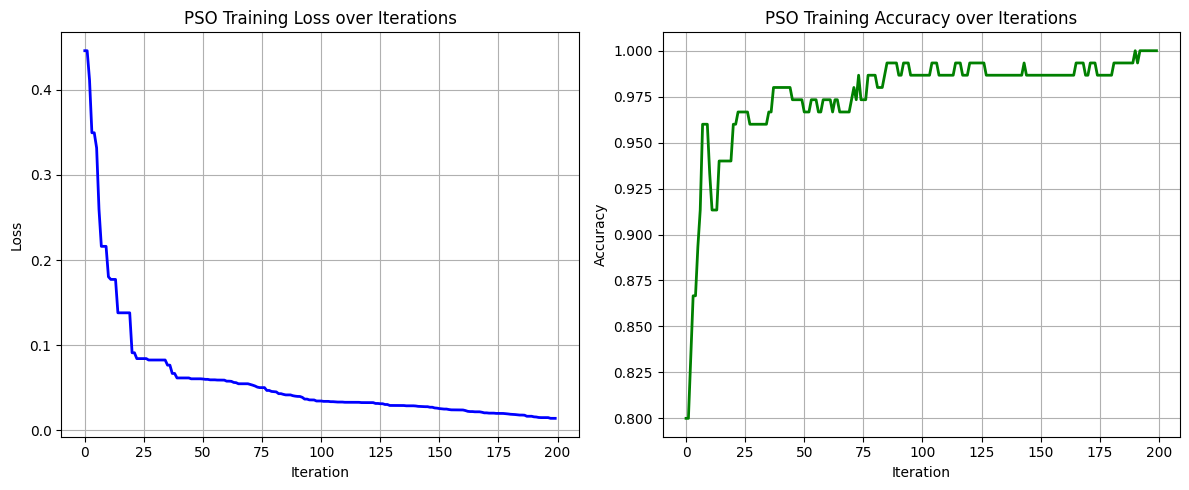

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss over iterations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(pso_loss, color='blue', linewidth=2)
plt.title("PSO Training Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)

# Plot Accuracy over iterations
plt.subplot(1, 2, 2)
plt.plot(pso_acc, color='green', linewidth=2)
plt.title("PSO Training Accuracy over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

### **Combined Plotting for Metaheuristic Algorithm**

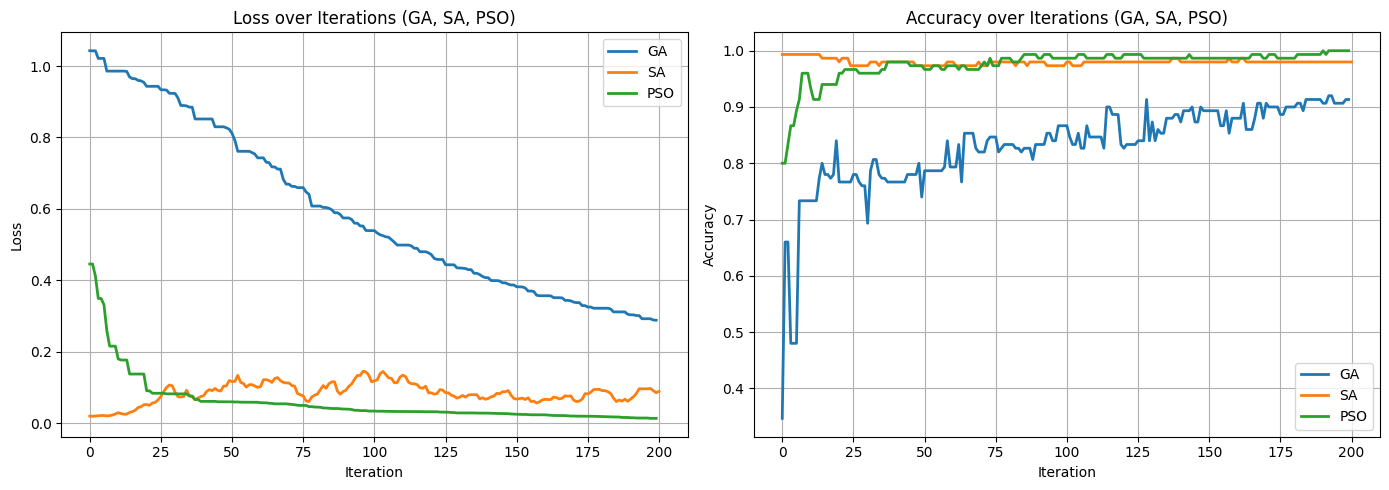

In [ ]:
import matplotlib.pyplot as plt

# --- Loss Plot ---
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(ga_loss, label="GA", linewidth=2)
plt.plot(sa_loss, label="SA", linewidth=2)
plt.plot(pso_loss, label="PSO", linewidth=2)
plt.title("Loss over Iterations (GA, SA, PSO)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# --- Accuracy Plot ---
plt.subplot(1, 2, 2)
plt.plot(ga_acc, label="GA", linewidth=2)
plt.plot(sa_acc, label="SA", linewidth=2)
plt.plot(pso_acc, label="PSO", linewidth=2)
plt.title("Accuracy over Iterations (GA, SA, PSO)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### **MNIST DATASET using CNN APP-1**

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Load MNIST
mnist = fetch_openml('mnist_784', version=1)
X = mnist['data'].to_numpy().reshape(-1, 28, 28) / 255.0
y = mnist['target'].astype(np.int64).to_numpy()

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.1, random_state=42)


In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return x > 0

def softmax(x):
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy(preds, labels):
    return -np.sum(labels * np.log(preds + 1e-8)) / preds.shape[0]

def cross_entropy_deriv(preds, labels):
    return (preds - labels) / preds.shape[0]


In [ ]:
class SimpleCNN:
    def __init__(self):
        rng = np.random.default_rng(42)
        # Conv layer: 3x3 kernel, 1 filter
        self.conv_filter = rng.normal(0, 0.1, (3, 3))
        self.conv_bias = 0.0

        # Dense layer: 13x13 (after 2x2 pooling on 26x26 conv output)
        self.fc1_W = rng.normal(0, 0.1, (13*13, 128))
        self.fc1_b = np.zeros(128)
        self.fc2_W = rng.normal(0, 0.1, (128, 10))
        self.fc2_b = np.zeros(10)

    def convolve(self, x):
        h, w = x.shape
        out = np.zeros((h - 2, w - 2))
        for i in range(h - 2):
            for j in range(w - 2):
                region = x[i:i+3, j:j+3]
                out[i, j] = np.sum(region * self.conv_filter) + self.conv_bias
        return out

    def max_pool(self, x):
        h, w = x.shape
        out = np.zeros((h//2, w//2))
        self.pool_cache = np.zeros_like(x, dtype=bool)
        for i in range(0, h, 2):
            for j in range(0, w, 2):
                region = x[i:i+2, j:j+2]
                max_val = np.max(region)
                out[i//2, j//2] = max_val
                # mask for backprop
                mask = (region == max_val)
                self.pool_cache[i:i+2, j:j+2] = mask
        return out

    def forward(self, x):
        self.x = x
        self.conv_out = self.convolve(x)
        self.relu1 = relu(self.conv_out)
        self.pooled = self.max_pool(self.relu1)
        self.flat = self.pooled.flatten()[np.newaxis, :]
        self.fc1_out = relu(self.flat @ self.fc1_W + self.fc1_b)
        self.logits = self.fc1_out @ self.fc2_W + self.fc2_b
        self.out = softmax(self.logits)
        return self.out

    def backward(self, y_true, lr=0.01):
        dout = cross_entropy_deriv(self.out, y_true)

        d_fc2_W = self.fc1_out.T @ dout
        d_fc2_b = np.sum(dout, axis=0)
        d_fc1 = dout @ self.fc2_W.T
        d_fc1[self.fc1_out <= 0] = 0  # ReLU backprop

        d_fc1_W = self.flat.T @ d_fc1
        d_fc1_b = np.sum(d_fc1, axis=0)
        d_flat = d_fc1 @ self.fc1_W.T
        d_pooled = d_flat.reshape(13, 13)

        # Upsample through max-pool
        d_relu1 = np.zeros_like(self.relu1)
        idxs = np.where(self.pool_cache)
        d_relu1[idxs] = np.repeat(np.repeat(d_pooled, 2, axis=0), 2, axis=1).flatten()[:len(idxs[0])]

        d_conv = d_relu1 * relu_deriv(self.conv_out)

        d_filter = np.zeros_like(self.conv_filter)
        for i in range(26):
            for j in range(26):
                region = self.x[i:i+3, j:j+3]
                d_filter += region * d_conv[i, j]
        d_bias = np.sum(d_conv)

        # Update parameters
        self.fc2_W -= lr * d_fc2_W
        self.fc2_b -= lr * d_fc2_b
        self.fc1_W -= lr * d_fc1_W
        self.fc1_b -= lr * d_fc1_b
        self.conv_filter -= lr * d_filter
        self.conv_bias -= lr * d_bias


In [ ]:
model = SimpleCNN()
epochs = 5
batch_size = 64

for epoch in range(epochs):
    indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]

    total_loss = 0
    correct = 0

    for i in range(0, len(X_train), batch_size):
        batch_X = X_train_shuffled[i:i+batch_size]
        batch_y = y_train_shuffled[i:i+batch_size]

        for x_sample, y_sample in zip(batch_X, batch_y):
            out = model.forward(x_sample)
            total_loss += cross_entropy(out, y_sample[np.newaxis, :])
            correct += int(np.argmax(out) == np.argmax(y_sample))
            model.backward(y_sample[np.newaxis, :])

    acc = correct / len(X_train)
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.4f}")


Epoch 1: Loss = 106111.8143, Accuracy = 0.3666
Epoch 2: Loss = 15869.1918, Accuracy = 0.9218


KeyboardInterrupt: 

In [ ]:
correct = 0
for x, y in zip(X_test, y_test):
    out = model.forward(x)
    correct += int(np.argmax(out) == np.argmax(y))
print(f"Test Accuracy: {correct / len(X_test):.4f}")


### **MNIST DATASET using CNN APP-2**

In [ ]:
import numpy as np

# ----------------------------- CNN Layer Implementations -----------------------------

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def cross_entropy_loss(predictions, labels):
    m = labels.shape[0]
    log_likelihood = -np.log(predictions[range(m), labels])
    return np.sum(log_likelihood) / m

def compute_accuracy(predictions, labels):
    return np.mean(np.argmax(predictions, axis=1) == labels)

# ----------------------------- Layer Definitions -----------------------------

class Conv2D:
    def __init__(self, num_filters, filter_size, input_depth):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.input_depth = input_depth
        self.filters = np.random.randn(num_filters, input_depth, filter_size, filter_size) * 0.1

    def forward(self, input):
        self.last_input = input
        batch_size, depth, height, width = input.shape
        output_height = height - self.filter_size + 1
        output_width = width - self.filter_size + 1
        output = np.zeros((batch_size, self.num_filters, output_height, output_width))

        for i in range(output_height):
            for j in range(output_width):
                region = input[:, :, i:i+self.filter_size, j:j+self.filter_size]
                for f in range(self.num_filters):
                    output[:, f, i, j] = np.sum(region * self.filters[f], axis=(1, 2, 3))
        return relu(output)

class MaxPool2D:
    def __init__(self, size):
        self.size = size

    def forward(self, input):
        self.last_input = input
        batch_size, depth, height, width = input.shape
        output = np.zeros((batch_size, depth, height // 2, width // 2))

        for i in range(0, height, 2):
            for j in range(0, width, 2):
                region = input[:, :, i:i+2, j:j+2]
                output[:, :, i//2, j//2] = np.max(region, axis=(2, 3))
        return output

class Flatten:
    def forward(self, input):
        self.input_shape = input.shape
        return input.reshape(input.shape[0], -1)

class Dense:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.1
        self.biases = np.zeros(output_size)

    def forward(self, input):
        self.last_input = input
        return np.dot(input, self.weights) + self.biases

# ----------------------------- CNN Model -----------------------------

class SimpleCNN:
    def __init__(self):
        self.conv = Conv2D(num_filters=4, filter_size=3, input_depth=1)
        self.pool = MaxPool2D(size=2)
        self.flatten = Flatten()
        self.dense1 = Dense(1696, 128)  # Calculated output size after conv + pool
        self.dense2 = Dense(128, 10)

    def forward(self, x):
        x = self.conv.forward(x)
        x = self.pool.forward(x)
        x = self.flatten.forward(x)
        x = relu(self.dense1.forward(x))
        x = self.dense2.forward(x)
        return softmax(x)

# ----------------------------- Summary -----------------------------

cnn_model = SimpleCNN()
"Model constructed: Conv(3x3x1x4) -> Pool(2x2) -> Dense(1696→128) -> Dense(128→10)"

'Model constructed: Conv(3x3x1x4) -> Pool(2x2) -> Dense(1696→128) -> Dense(128→10)'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and std for MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define optimal CNN model using PyTorch
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # output: 32x28x28
        self.pool1 = nn.MaxPool2d(2, 2)                          # output: 32x14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # output: 64x14x14
        self.pool2 = nn.MaxPool2d(2, 2)                          # output: 64x7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model, loss, optimizer
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train for 1 epoch to compute baseline
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    average_loss = total_loss / total
    return average_loss, accuracy

# Train for 1 epoch (baseline)
model.train()
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    break  # only train on one batch for now (baseline eval)

# Evaluate on test set
baseline_loss, baseline_accuracy = evaluate_model(model, test_loader)
baseline_loss, baseline_accuracy


100%|██████████| 9.91M/9.91M [00:00<00:00, 31.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.13MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.90MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.83MB/s]


(2.2714994668960573, 0.1577)

### **Fashion-MNIST**

In [5]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize and reshape
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# One-hot encode labels
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

print("Shapes:", X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)


Shapes: (60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [7]:
import numpy as np

# Define activation functions
def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # for numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Define cross-entropy loss
def cross_entropy(predictions, targets):
    epsilon = 1e-12
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce_loss = -np.sum(targets * np.log(predictions)) / N
    return ce_loss

def accuracy(predictions, labels):
    return np.mean(np.argmax(predictions, axis=1) == np.argmax(labels, axis=1))

In [8]:
class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        self.stride = stride
        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        # Xavier initialization
        limit = np.sqrt(6 / (in_channels * kernel_size * kernel_size + out_channels))
        self.weights = np.random.uniform(-limit, limit,
                                         (out_channels, in_channels, kernel_size, kernel_size))
        self.bias = np.zeros((out_channels, 1))

    def forward(self, x):
        self.input = x
        batch_size, in_c, in_h, in_w = x.shape
        k = self.kernel_size
        s = self.stride
        out_h = (in_h - k) // s + 1
        out_w = (in_w - k) // s + 1
        out = np.zeros((batch_size, self.out_channels, out_h, out_w))

        for b in range(batch_size):
            for o in range(self.out_channels):
                for i in range(0, out_h):
                    for j in range(0, out_w):
                        for c in range(in_c):
                            out[b, o, i, j] += np.sum(
                                x[b, c, i*s:i*s+k, j*s:j*s+k] * self.weights[o, c]
                            )
                        out[b, o, i, j] += self.bias[o]
        self.output = relu(out)
        return self.output

class MaxPool2D:
    def __init__(self, size=2, stride=2):
        self.size = size
        self.stride = stride

    def forward(self, x):
        self.input = x
        batch_size, channels, height, width = x.shape
        out_h = (height - self.size) // self.stride + 1
        out_w = (width - self.size) // self.stride + 1
        out = np.zeros((batch_size, channels, out_h, out_w))

        for b in range(batch_size):
            for c in range(channels):
                for i in range(out_h):
                    for j in range(out_w):
                        h_start = i * self.stride
                        h_end = h_start + self.size
                        w_start = j * self.stride
                        w_end = w_start + self.size
                        out[b, c, i, j] = np.max(x[b, c, h_start:h_end, w_start:w_end])
        self.output = out
        return out

class Flatten:
    def forward(self, x):
        self.input_shape = x.shape
        return x.reshape(x.shape[0], -1)

class Dense:
    def __init__(self, in_features, out_features):
        # He initialization
        limit = np.sqrt(2 / in_features)
        self.weights = np.random.randn(in_features, out_features) * limit
        self.bias = np.zeros((1, out_features))

    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.bias


In [9]:
# Define CNN architecture
class CNN_Model:
    def __init__(self):
        self.conv1 = Conv2D(1, 8, kernel_size=3)
        self.pool1 = MaxPool2D()
        self.conv2 = Conv2D(8, 16, kernel_size=3)
        self.pool2 = MaxPool2D()
        self.flatten = Flatten()
        self.fc1 = Dense(400, 128)
        self.fc2 = Dense(128, 10)

    def forward(self, x):
        out = self.conv1.forward(x)
        out = self.pool1.forward(out)
        out = self.conv2.forward(out)
        out = self.pool2.forward(out)
        out = self.flatten.forward(out)
        out = relu(self.fc1.forward(out))
        out = softmax(self.fc2.forward(out))
        return out

In [11]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Load data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize and reshape
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Reshape to (batch, channels, height, width)
x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train_oh = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_oh = encoder.transform(y_test.reshape(-1, 1))

In [13]:
cnn = CNN_Model()

# Run forward pass on all test samples
output_test = cnn.forward(x_test)  # Shape: (10000, 10)

# Compute loss and accuracy
test_loss = cross_entropy(output_test, y_test_oh)
test_acc = accuracy(output_test, y_test_oh)

print(f"[Full Test Set] Baseline Loss (Untrained CNN): {test_loss:.4f}")
print(f"[Full Test Set] Baseline Accuracy (Untrained CNN): {test_acc:.4f}")

/tmp/ipython-input-8-1681418681.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[b, o, i, j] += self.bias[o]
/tmp/ipython-input-8-1681418681.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[b, o, i, j] += self.bias[o]
/tmp/ipython-input-8-1681418681.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[b, o, i, j] += self.bias[o]
/tmp/ipython-input-8-1681418681.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is depreca

[Full Test Set] Baseline Loss (Untrained CNN): 2.5491
[Full Test Set] Baseline Accuracy (Untrained CNN): 0.1237


### Large CNN for GA and all

In [26]:
import numpy as np

def initialize_large_cnn_params():
    # Conv Layer 1: 1 input channel → 32 filters of size 3x3
    W1 = np.random.randn(32, 1, 3, 3) * np.sqrt(2 / (1 * 3 * 3))
    b1 = np.zeros(32)

    # Conv Layer 2: 32 input channels → 64 filters of size 3x3
    W2 = np.random.randn(64, 32, 3, 3) * np.sqrt(2 / (32 * 3 * 3))
    b2 = np.zeros(64)

    # flattened size after 2 conv + 2 pool layers: 64 * 5 * 5 = 1600
    W3 = np.random.randn(128, 1600) * np.sqrt(2 / 1600)
    b3 = np.zeros(128)

    # Output layer (128 → 10)
    W4 = np.random.randn(10, 128) * np.sqrt(2 / 128)
    b4 = np.zeros(10)

    return [W1, b1, W2, b2, W3, b3, W4, b4]

In [27]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def conv2d(X, W, b, stride=1, padding=0):
    N, C, H, W_in = X.shape
    F, _, HH, WW = W.shape

    H_out = (H + 2 * padding - HH) // stride + 1
    W_out = (W_in + 2 * padding - WW) // stride + 1

    X_padded = np.pad(X, ((0, 0), (0, 0), (padding, padding), (padding, padding)))
    out = np.zeros((N, F, H_out, W_out))

    for n in range(N):
        for f in range(F):
            for i in range(H_out):
                for j in range(W_out):
                    region = X_padded[n, :, i*stride:i*stride+HH, j*stride:j*stride+WW]
                    out[n, f, i, j] = np.sum(region * W[f]) + b[f]
    return out

def max_pool(X, size=2, stride=2):
    N, C, H, W = X.shape
    H_out = (H - size) // stride + 1
    W_out = (W - size) // stride + 1
    out = np.zeros((N, C, H_out, W_out))

    for n in range(N):
        for c in range(C):
            for i in range(H_out):
                for j in range(W_out):
                    out[n, c, i, j] = np.max(X[n, c, i*stride:i*stride+size, j*stride:j*stride+size])
    return out

def forward_pass(X, params):
    W1, b1, W2, b2, W3, b3, W4, b4 = params

    out1 = relu(conv2d(X, W1, b1, padding=0))        # Conv1
    out1p = max_pool(out1)                           # Pool1

    out2 = relu(conv2d(out1p, W2, b2, padding=0))     # Conv2
    out2p = max_pool(out2)                           # Pool2

    out_flat = out2p.reshape(out2p.shape[0], -1)     # Flatten
    fc1 = relu(np.dot(out_flat, W3.T) + b3)          # FC1
    out_final = softmax(np.dot(fc1, W4.T) + b4)      # Output
    return out_final


In [1]:
#import necessary modules after kernel reset
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

# Load Fashion-MNIST
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train[:100]  # Using a smaller batch for quick test
y_train = y_train[:100]

# Normalize and reshape
X_train = X_train / 255.0
X_train = X_train.reshape(-1, 1, 28, 28)  # NCHW format
y_train_onehot = to_categorical(y_train, 10)

# Activation Functions
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

# CNN Layers
def conv2d(X, W, b, stride=1, padding=0):
    N, C, H, W_in = X.shape
    F, _, HH, WW = W.shape

    H_out = (H + 2 * padding - HH) // stride + 1
    W_out = (W_in + 2 * padding - WW) // stride + 1

    X_padded = np.pad(X, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant')
    out = np.zeros((N, F, H_out, W_out))

    for n in range(N):
        for f in range(F):
            for i in range(H_out):
                for j in range(W_out):
                    region = X_padded[n, :, i*stride:i*stride+HH, j*stride:j*stride+WW]
                    out[n, f, i, j] = np.sum(region * W[f]) + b[f]
    return out

def max_pool(X, size=2, stride=2):
    N, C, H, W = X.shape
    H_out = (H - size) // stride + 1
    W_out = (W - size) // stride + 1
    out = np.zeros((N, C, H_out, W_out))

    for n in range(N):
        for c in range(C):
            for i in range(H_out):
                for j in range(W_out):
                    out[n, c, i, j] = np.max(X[n, c, i*stride:i*stride+size, j*stride:j*stride+size])
    return out

# Forward Pass
def initialize_large_cnn_params():
    # Conv Layer 1: 1 input channel → 32 filters of size 3x3
    W1 = np.random.randn(32, 1, 3, 3) * np.sqrt(2 / (1 * 3 * 3))
    b1 = np.zeros(32)

    # Conv Layer 2: 32 input channels → 64 filters of size 3x3
    W2 = np.random.randn(64, 32, 3, 3) * np.sqrt(2 / (32 * 3 * 3))
    b2 = np.zeros(64)

    #flattened size after 2 conv + 2 pool layers: 64 * 5 * 5 = 1600
    W3 = np.random.randn(128, 1600) * np.sqrt(2 / 1600)
    b3 = np.zeros(128)

    # Output layer (128 → 10)
    W4 = np.random.randn(10, 128) * np.sqrt(2 / 128)
    b4 = np.zeros(10)

    return [W1, b1, W2, b2, W3, b3, W4, b4]

def forward_pass(X, params):
    W1, b1, W2, b2, W3, b3, W4, b4 = params
    out1 = relu(conv2d(X, W1, b1))
    out1p = max_pool(out1)
    out2 = relu(conv2d(out1p, W2, b2))
    out2p = max_pool(out2)
    out_flat = out2p.reshape(out2p.shape[0], -1)
    fc1 = relu(np.dot(out_flat, W3.T) + b3)
    out_final = softmax(np.dot(fc1, W4.T) + b4)
    return out_final

# Loss
def compute_loss(y_pred, y_true):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

# Run test
params = initialize_large_cnn_params()
output = forward_pass(X_train, params)
loss = compute_loss(output, y_train_onehot)
accuracy = np.mean(np.argmax(output, axis=1) == y_train)

loss, accuracy

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


(np.float64(2.741956537649129), np.float64(0.12))

### **GA for CNN**

In [3]:
import numpy as np
import random
# --- Step 1: Flatten/Unflatten Parameters ---

def flatten_params(params):
    return np.concatenate([p.flatten() for p in params])

def unflatten_params(genome, param_shapes):
    params = []
    idx = 0
    for shape in param_shapes:
        size = np.prod(shape)
        param = genome[idx:idx+size].reshape(shape)
        params.append(param)
        idx += size
    return params

# Save original shapes for reconstruction
def get_param_shapes(params):
    return [p.shape for p in params]

# --- Step 2: Fitness Function ---

def fitness_function(genome, param_shapes, X, y):
    params = unflatten_params(genome, param_shapes)
    y_pred = forward_pass(X, params)
    loss = compute_loss(y_pred, y)
    acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
    return -loss, acc  # Negative loss because GA maximizes

# --- Step 3: GA Core ---

def initialize_population(size, genome_length):
    return [np.random.randn(genome_length) * 0.1 for _ in range(size)]

def select_top(population, scores, top_k):
    sorted_idx = np.argsort([-s[0] for s in scores])  # sort by fitness (negative loss)
    return [population[i] for i in sorted_idx[:top_k]]

def crossover(parent1, parent2):
    point = np.random.randint(1, len(parent1) - 1)
    child = np.concatenate([parent1[:point], parent2[point:]])
    return child

def mutate(genome, rate=0.05, strength=0.1):
    mutation = np.random.rand(len(genome)) < rate
    genome[mutation] += np.random.randn(np.sum(mutation)) * strength
    return genome

# --- Step 4: Run GA ---

def run_ga(X, y, generations=10, pop_size=20, top_k=5, mutation_rate=0.05):
    # Initial random weights
    base_params = initialize_large_cnn_params()
    param_shapes = get_param_shapes(base_params)
    genome_len = len(flatten_params(base_params))

    population = initialize_population(pop_size, genome_len)

    for gen in range(generations):
        scores = [fitness_function(g, param_shapes, X, y) for g in population]
        top_individuals = select_top(population, scores, top_k)

        print(f"Gen {gen}: Best Loss = {-scores[0][0]:.4f}, Acc = {scores[0][1]:.4f}")

        new_population = top_individuals.copy()

        while len(new_population) < pop_size:
            p1, p2 = random.sample(top_individuals, 2)
            child = crossover(p1, p2)
            child = mutate(child, rate=mutation_rate)
            new_population.append(child)

        population = new_population

    # Return best genome
    best_genome = select_top(population, [fitness_function(g, param_shapes, X, y) for g in population], 1)[0]
    best_params = unflatten_params(best_genome, param_shapes)
    return best_params


In [4]:
# Train using GA
best_params = run_ga(X_train, y_train_onehot, generations=10, pop_size=20)

# Evaluate
final_output = forward_pass(X_train, best_params)
final_loss = compute_loss(final_output, y_train_onehot)
final_acc = np.mean(np.argmax(final_output, axis=1) == y_train)

print(f"Final Loss: {final_loss:.4f}, Final Accuracy: {final_acc:.4f}")

Gen 0: Best Loss = 2.8405, Acc = 0.1300
Gen 1: Best Loss = 2.2951, Acc = 0.1500
Gen 2: Best Loss = 2.2570, Acc = 0.2000
Gen 3: Best Loss = 2.2417, Acc = 0.1500
Gen 4: Best Loss = 2.2181, Acc = 0.2000
Gen 5: Best Loss = 2.1844, Acc = 0.2500
Gen 6: Best Loss = 2.1844, Acc = 0.2500
Gen 7: Best Loss = 2.1537, Acc = 0.2300
Gen 8: Best Loss = 2.1537, Acc = 0.2300
Gen 9: Best Loss = 2.1537, Acc = 0.2300
Final Loss: 2.1156, Final Accuracy: 0.2800
